# Desarrollo proyecto Sistemas inteligentes
## Perfil de Consumidor

P2-PerfilCons
Integrantes: Michelle Soto Florido, Andrés Parra Rodríguez, Julio Alberto Parra Martínez, Carlos A. Talero Jacome

En este se describe el desarrollo del modelo de FUzzy KNN para identificar los posibles tipos de productos a comprar de un cliente en una página de internet. Esto se realizó con la base de datos Customer
Personality Analysis de la página de internet Kaggle.

### 1. Lectura base de datos

Se realiza lectura de la base de datos directamente del archivo descargado. Luego se eliminan variables que no contienen información (Z_CostContact y Z_Revenue) y las que no se emplearán para el modelo (ID y Complain)

In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import KFold

# Lectura datos
data = pd.read_csv("Customer Personality Analysis.csv",sep='\t')
# Eliminacion de variables no usadas
data.drop(['ID','Z_CostContact', 'Z_Revenue','Dt_Customer','Complain'], axis=1, inplace=True)
# Eliminacion de datos NaN
data = data.dropna()
data.reset_index(drop=True, inplace=True)

### 2. Transformación de las salidas
El propósito de este modelo es predecir con datos demográficos y de comportamiento qué artículos es más probable que compren los usuarios de la plataforma. Las salidas del sistema es un conjunto de datos binarios, donde cada dígito indica la probabilidad de que el usuario puede comprar el artículo o no.

Para esto se hace una frontera con la mediana de cada variable.

Mediana de Wines = 174.5
Media de Wines = 305.09160649819495
Mediana de Fruits = 8.0
Media de Fruits = 26.356046931407942
Mediana de Meats = 68.0
Media de Meats = 166.99593862815885


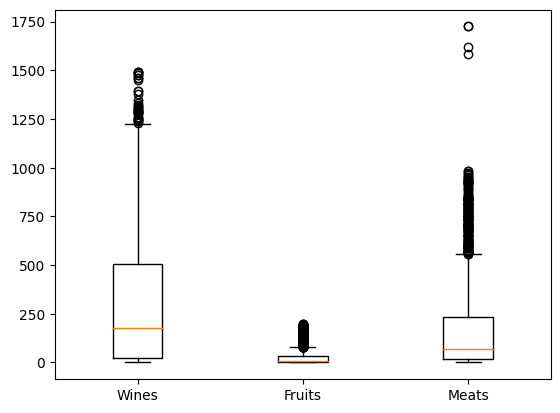

In [22]:
# Sustrae los targets
targets = data.loc[:, ["MntWines","MntFruits","MntMeatProducts"]]
data.drop(["MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds"], axis=1, inplace=True)

# Transformacion de la salidas (6) Escoge las menores de la mitad de los datos (menores a mediana) con Normalizacion (z-score)
scalert = StandardScaler()
labels = pd.DataFrame(scalert.fit_transform(targets))
for i in range(targets.shape[1]):
    labels[i] = targets.iloc[:,i] >= np.median(targets.iloc[:,i])
labels = labels.replace({False: 0, True: 1})

# Frontera de desición mediana para binarizar targets
tarNames = ['Wines','Fruits','Meats']
for i in range(targets.shape[1]):
    print('Mediana de ' + tarNames[i] + ' = ' + str(np.median(targets.iloc[:,i])))
    print('Media de ' + tarNames[i] + ' = ' + str(np.mean(targets.iloc[:,i])))

# Boxplot de targets sin normalizar
plt.boxplot(targets,labels=tarNames);

## 3. Transformaciones a datos de entrada

Se toquenizó en número dos variables que venían como texto (Education y Marital_Status). Se generaron dos nuevas variables que dan información sobre el total de compras y el total de promociones acptadas por cada persona. Finalmente se realizó una estandarización con Z-Score

In [23]:
# Strings a numeros (Tokenizacion)
label_encoder = LabelEncoder()
data['Education'] = label_encoder.fit_transform(data['Education'])
data['Marital_Status'] = label_encoder.fit_transform(data['Marital_Status'])

# Nuevas variables
# Total promociones aceptadas
data['Total promociones'] = data['AcceptedCmp3']+data['AcceptedCmp4']+data['AcceptedCmp5']+data['AcceptedCmp1']+data['AcceptedCmp2']+data['Response']
# Total compras realizadas
data['Total Compras'] = data['NumDealsPurchases']+data['NumWebPurchases']+data['NumCatalogPurchases']+data['NumStorePurchases']

data.drop(['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Response'], axis=1, inplace=True)

# Normalizacion a todas (z-score)
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Transformacion de la salidas (6) Escoge las menores de la mitad de los datos (menores a mediana) con Normalizacion (z-score)
scalert = StandardScaler()
labels = pd.DataFrame(scalert.fit_transform(targets))
for i in range(targets.shape[1]):
    labels[i] = targets.iloc[:,i] >= np.median(targets.iloc[:,i])
labels = np.array(labels.replace({False: 0, True: 1}))


## 4. Algorítmo Fuzzy KNN
El algorítmo Fuzzy K-NN fue implementado a parir del artículo cientifico "A Fuzzy ΛΓ-Nearest Neighbor Algorithm" de JAMES M. KELLER, MICHAEL R. GRAY, AND JAMES A. GIVENS, JR.

Este tiene como salida una matriz de pertenencias, donde muestra el grado de pertenencia a cada clase de cada observación. Para poder comparar los resultados de este con las otras clasificaciones, se generó un umbral, donde la observación con mayor valor de pertenencia, quedará con esa clase.


In [17]:
def FuzzyKnn(X_train, y_train, X_test, k=3, m=2):
    # Definimos el número de vecinos (k) tiene que ser impar (55)
    # k = 5
    # Conversión de labels a dumies
    df = pd.get_dummies(pd.DataFrame(y_train).astype(str))
    df = np.matrix(df.astype(int))
    # Prediccion de datos test con datos train (el conjunuto es el modelo)
    u = []
    # m = 0.01
    classes = list(set(y_train))
    for x in range(len(X_test)):
        # Calcula distancia entre observacion y conjunto de datos
        distance = np.linalg.norm(X_train - X_test[x], axis=1)
        # Ordena de menor a mayor las distancias y entrega sus indices
        sorted_indices = np.argsort(distance)
        # Entrega los indices de las observaciones más cercanas y excluye el punto en sí mismo
        neighbors = sorted_indices[0:k]
        # Calculo fuzzy (ver artículo para la ecuación)
        votes = []
        for c in classes:
            den = 0
            for i in range(k):
                dist = np.linalg.norm(X_test[x] - X_train[neighbors[i],:])
                den += 1 / (dist ** (2 / (m-1)))
            neighbors_votes = []
            for i in range(k):
                dist = np.linalg.norm(X_test[x] - X_train[neighbors[i],:])
                num = df[neighbors[i], c] / (dist ** (2 / (m-1)))
                vote = num/den
                neighbors_votes.append(vote)
            votes.append(np.sum(neighbors_votes))
        u.append(votes)
    # conversión de pertenencias fuzzy
    u = np.array(u)
    y_pred = np.array([])
    for i in range(len(u)):
        y_pred = np.append(y_pred, np.argmax(u[i]))
    return y_pred

## 5. Función para calcular métricas de cada clasificación
Como se va a realizar un k-fold, se realizó una función para obtener las métricas de cada clasificación.

In [26]:
# Matriz de confusion y scores
def confu(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    exactitud = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    especificidad = TN / (TN + FP)
    sensibilidad = TP / (TP + FN)
    f1 = 2*TP / (2*TP + FP + FN)
    # print(confusion)
    # print(f"Exactitud = {exactitud:,.2f}")
    # print(f"Precisión = {precision:,.2f}")
    # print(f"Especificidad = {especificidad:,.2f}")
    # print(f"Sensibilidad = {sensibilidad:,.2f}")
    # print(f"F1 = {f1:,.2f}")
    # print(" ")
    return dict(exactitud = exactitud, precision = precision,
            especificidad = especificidad, sensibilidad = sensibilidad, f1 = f1)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## 6. Evaluación de modelo Fuzzy K-NN con k-Fold de 10 iteraciones

Se emplea un k-Fold de 10 iteraciones para evitar el sesgo de elegir una semilla para una sola clasificaicón. Al ser 10 iteraciones de clasificaicones, se obtienen un conjunto de datos por cada métrica. A cada uno se le calcula la media y la desviación estandar.

In [27]:
tipo = ["MntWines","MntFruits","MntMeatProducts"]

for j in range(3):

    print(f"Prediciendo {tipo[j]}")

    sens = []
    f1 = []
    espe = []
    exac = []
    pres = []
    # Crear un objeto KFold
    kf = KFold(n_splits=10)
    # Iterar sobre los conjuntos de entrenamiento y prueba generados por KFold
    for train_index, test_index in kf.split(data):
        X_train, X_test = [data[i] for i in train_index], [data[i] for i in test_index]
        y_train, y_test = [labels[:,j][i] for i in train_index], [labels[:,j][i] for i in test_index]
        X_train = np.matrix(X_train)
        X_test = np.matrix(X_test)
        y_pred = FuzzyKnn(X_train, y_train, X_test, k=5, m=0.02)
        # Rendimiento
        rendi = confu(y_test, y_pred)
        sens.append(rendi["sensibilidad"])
        f1.append(rendi["f1"])
        espe.append(rendi["especificidad"])
        exac.append(rendi["exactitud"])
        pres.append(rendi["precision"])

    # Media y desviacion estandar de las métricas del k-fold
    exm = np.mean(exac)
    exs =np.std(exac)
    prem = np.mean(pres)
    pres = np.std(pres)
    espem = np.mean(espe)
    espes = np.std(espe)
    sensm = np.mean(sens)
    senss = np.std(sens)
    f1m = np.mean(f1)
    f1s = np.std(f1)


    print(f"Exactitud = {exm:,.2f} ± {exs:,.2f}")
    print(f"Precisión = {prem:,.2f} ± {pres:,.2f}")
    print(f"Especificidad = {espem:,.2f} ± {espes:,.2f}")
    print(f"Sensibilidad = {sensm:,.2f} ± {senss:,.2f}")
    print(f"F1 = {f1m:,.2f} ± {f1s:,.2f}")
    print(" ")

Prediciendo MntWines
Exactitud = 0.92 ± 0.02
Precisión = 0.91 ± 0.03
Especificidad = 0.90 ± 0.03
Sensibilidad = 0.94 ± 0.02
F1 = 0.92 ± 0.02
 
Prediciendo MntFruits
Exactitud = 0.79 ± 0.02
Precisión = 0.79 ± 0.05
Especificidad = 0.79 ± 0.03
Sensibilidad = 0.78 ± 0.04
F1 = 0.79 ± 0.03
 
Prediciendo MntMeatProducts
Exactitud = 0.89 ± 0.02
Precisión = 0.89 ± 0.03
Especificidad = 0.89 ± 0.03
Sensibilidad = 0.89 ± 0.03
F1 = 0.89 ± 0.02
 
